# Assignment 12 - Viraj Noorithaya


## Script Parameters


In [1]:
# Where are you running this? Can be either 'local' or 'colab'
model_run_location = "local"

# # Do you want to install the required packages?
# install_required_packages = False
install_required_packages = False if model_run_location == "local" else True

# git repository url
repo_name = "era-v1"
git_repo_url = "https://github.com/nviraj/era-v1.git"

# Is the model being developed or is it in production?
# Can be development or production
code_mode = "development"

# WHich branch are you working on?
branch_name = "week-12" if code_mode == "development" else "main"
folder_name = "Session 12/Submission"

## Library Installation (Optional)


In [2]:
# # Install any required libraries not present in your working environment

if install_required_packages:
    # # Needed locally and in colab
    # !pip install torchsummary
    # !conda install -c frgfm torchscan

    # Run this cell if you are using colab or local machine
    import sys
    # https://lightning.ai/docs/pytorch/stable/
    !{sys.executable} -m pip install -q lightning
    # https://github.com/davidtvs/pytorch-lr-finder
    !{sys.executable} -m pip install -q torch-lr-finder
    # https://github.com/tyleryep/torchinfo
    !{sys.executable} -m pip install -q torchinfo
    # https://github.com/jacobgil/pytorch-grad-cam
    !{sys.executable} -m pip install -q grad-cam
    # https://www.gradio.app/
    !{sys.executable} -m pip install -q gradio

    # Needed in local machine only
    if model_run_location == 'local':
        %conda install --yes --prefix {sys.prefix} -c conda-forge tqdm
        %conda install --yes --prefix {sys.prefix} -c anaconda ipywidgets
        %conda install --yes --prefix {sys.prefix} -c conda-forge imgaug
        %conda install --yes --prefix {sys.prefix} -c conda-forge albumentations       


## Code Procurement


In [3]:
import sys
import os

# Current working directory
print(f"CWD: {os.getcwd()}")

# Mount google drive if running on colab
if model_run_location == 'colab':
    # from google.colab import drive
    # drive.mount('/content/drive')
    # %cd /content/drive/MyDrive/WorkSpace/era-v1/Session 10/Submission

    # Delete the folder if it exists
    # Avoids fatal: destination path already exists and is not an empty directory.
    # Get code from github
    !rm -rf {repo_name} && git clone {git_repo_url}

    # Switch to repo folder, Needed to switch branch
    # Switch branch and change to the correct directory
    !cd "{repo_name}" && git checkout {branch_name} && cd "{folder_name}"

    # Make custom modules available
    print(f"Appending folder to path in order to detect modules: {folder_name}")
    sys.path.append(f"era-v1/{folder_name}")

CWD: d:\Root\Personal\WorkSpace\era-v1\Session 12\Submission


## Import Libraries


In [4]:
# Import necessary modules (external libs)
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
from pytorch_lightning import LightningModule, Trainer
from torchmetrics import Accuracy
from lightning_fabric.utilities.seed import seed_everything

In [12]:
if code_mode == "development":
    %load_ext autoreload
    %autoreload 2

# Import user defined modules
from models.custom_resnet import CustomResNet as Net
from models.custom_resnet import detailed_model_summary
from modules.dataset import CIFAR_CLASSES
from modules.lightning_dataset import CIFARDataModule
from modules.trainer import train_and_test_model
from modules.utils import get_device, get_num_workers, pretty_print_metrics, save_model
from modules.visualize import (
    plot_gradcam_images,
    plot_misclassified_images,
    plot_sample_training_images,
    plot_train_test_metrics,
)

## Script Parameters


In [6]:
# Constants naming convention: All caps separated by underscore
# https://realpython.com/python-constants/

# Where do we store the data?
data_path = "../../data"
checkpoint_path = "../../checkpoints"

# Specify the number of epochs
NUM_EPOCHS = 2

# Set the batch size
BATCH_SIZE = 512

# Set seed value for reproducibility
SEED = 26

# Expected accuracy
TARGET_ACCURACY = 90.0

## Get Device and Workers


In [7]:
# Functionality to check cuda support and create device is now moved to utils.py
device_support, device = get_device()

# How many workers do you need?
num_workers = get_num_workers(model_run_location)

print(
    f"Run location: {model_run_location}, \n",
    # f"Device: {device_support}, \n",
    f"Number of workers: {num_workers}, \n",
    f"Batch size: {BATCH_SIZE} \n",
    f"Seed: {SEED} \n",
    f"Data path: {data_path} \n",
    f"Checkpoint path: {checkpoint_path}"
)

Run location: local, 
 Number of workers: 0, 
 Batch size: 512 
 Seed: 26 
 Data path: ../../data 
 Checkpoint path: ../../checkpoints


### Reproducibility settings


In [8]:
# # For reproducibility
# # https://pytorch.org/docs/stable/notes/randomness.html
# # https://github.com/pytorch/pytorch/issues/7068
# import random
# import numpy as np

# torch.manual_seed(SEED)
# random.seed(SEED)
# np.random.seed(SEED)

# if device_support == "cuda":
#     torch.cuda.manual_seed(SEED)
#     torch.cuda.manual_seed_all(SEED)


seed_everything(SEED)

Global seed set to 26


26

## Dataloaders/ Datamodule


In [9]:
# Get the data module
cifar_data_module = CIFARDataModule(data_path = data_path, batch_size = BATCH_SIZE, num_workers = num_workers, seed = SEED)
cifar_data_module.setup()

# Extract the train and test dataloaders
# train_loader = cifar_data_module.training_dataset
# val_loader = cifar_data_module.validation_dataset
# test_loader = cifar_data_module.testing_dataset

train_loader = cifar_data_module.train_dataloader()
val_loader = cifar_data_module.val_dataloader()
test_loader = cifar_data_module.test_dataloader()

# Get class mapping for the dataset
classes = CIFAR_CLASSES
print(f"Class Labels: {classes}")

Class Labels: ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')


## Sample Training Images


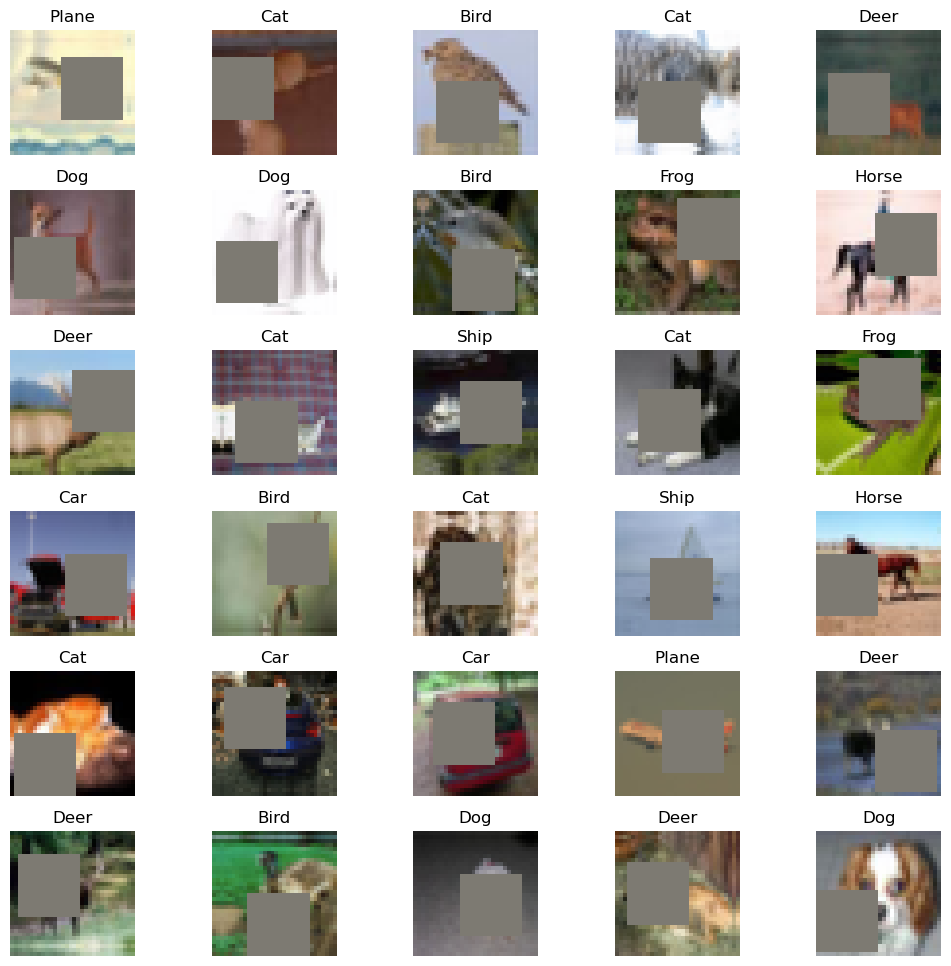

In [10]:
# Get a batch of training data from train_loader
batch_data, batch_label = next(iter(train_loader))

# Plot 30 sample images from the training data along with their labels
# plot_sample_training_images() imported from utils.py
fig, axs = plot_sample_training_images(batch_data, batch_label, class_label=classes, num_images=30)
plt.show()

## Model Summary


In [11]:
# Define the model
# No need to send the model to device as we are using the LightningModule
model = Net()

# enable printing shape
model.print_shape = True

# # Print the model summary by specifying the input size
# summary(model, input_size=(3, 32, 32))
detailed_model_summary(model, input_size=(3, 32, 32))

# disable printing shape for cleaner test train output
model.print_shape = False

PrepLayer 
	 torch.Size([1, 64, 32, 32]) 

Layer 1, X 
	 torch.Size([1, 128, 16, 16]) 

Layer 1, R1 
	 torch.Size([1, 128, 16, 16]) 

Layer 1, X + R1 
	 torch.Size([1, 128, 16, 16]) 

Layer 2 
	 torch.Size([1, 256, 8, 8]) 

Layer 3, X 
	 torch.Size([1, 512, 4, 4]) 

Layer 3, R2 
	 torch.Size([1, 512, 4, 4]) 

Layer 3, X + R2 
	 torch.Size([1, 512, 4, 4]) 

Max Pooling 
	 torch.Size([1, 512, 1, 1]) 

Reshape before FC 
	 torch.Size([1, 512]) 

After FC 
	 torch.Size([1, 10]) 

Layer (type:depth-idx)                   Input Shape      Kernel Shape     Output Shape     Param #          Trainable
CustomResNet                             [1, 3, 32, 32]   --               [1, 10]          --               True
├─Sequential: 1-1                        [1, 3, 32, 32]   --               [1, 64, 32, 32]  --               True
│    └─Conv2d: 2-1                       [1, 3, 32, 32]   [3, 3]           [1, 64, 32, 32]  1,728            True
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]  

## Train and Test


### Train and test model


In [ ]:
# Create a dictionary of lists for misclassified images, generated predictions and ground truth
misclassified_image_data = {"images": [], "ground_truths": [], "predicted_vals": []}

# Run the model for NUM_EPOCHS
results = train_and_test_model(
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    model=model
    train_loader=train_loader,
    test_loader=test_loader,
    val_loader=val_loader,
    misclassified_image_data=misclassified_image_data,
)

In [ ]:
# Pretty print train and test accuracy and loss values for each epoch
pretty_print_metrics(num_epochs=NUM_EPOCHS, results=results)

## Metrics


In [ ]:
# Print expected accuracy for easier reference
print(f"Expected accuracy: {TARGET_ACCURACY}%")

# Plot the accuracy and loss graphs using data and plot_train_test_metrics() from model.py
print("Plotting accuracy and loss graphs.")
fig, axs = plot_train_test_metrics(results)
plt.show()
# plt.savefig("Loss and Accuracy Metrics.png")

## Save model


In [ ]:
# Save model
print("Saving the model as the training is complete!")
save_model(
    epoch=NUM_EPOCHS,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=BATCH_SIZE,
    criterion=criterion,
    file_name="model_last_epoch.pth",
)

## Show Misclassified images


In [ ]:
# Plot misclassified images
fig, axs = plot_misclassified_images(data=misclassified_image_data, class_label=classes, num_images=10)
plt.show()
# plt.savefig("Misclassified Images.png")

## GradCAM (Misclassified)


In [ ]:
# Plot misclassified images
fig, axs = plot_gradcam_images(
    model=model,
    data=misclassified_image_data,
    class_label=classes,
    # Use penultimate block of resnet18 layer 3 as the target layer for gradcam
    # Decided using model summary so that dimensions > 7x7
    target_layers=[model.layer3[-1]],
    device=device_support,
    targets=None,
    num_images=10,
    image_weight=0.15,
)
plt.show()
# plt.savefig("GradCAM Images.png")